# Binarization
In this notebook, we demonstrate how to extract lane-lines from onboard image

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
import matplotlib.image as mpimg
import cv2
import numpy as np

In [2]:
# selected threshold to highlight yellow lines
yellow_HSV_th_min = np.array([0, 70, 70])
yellow_HSV_th_max = np.array([50, 255, 255])

# selected threshold to hightlight white lines
white_eq_thval = 250
white_eq_maxval = 255

# sobel kernel size
sobel_kernel_size = 9
sobel_thval = 50
sobel_maxval = 1

In [3]:
"""
Extract specific colour space from HSV colour space.
Args:
  img: input image
  th_min: minimum threshold
  th_max: maximum threshold

Return:
  mask of colour space array
"""
def mask_HSV(img, th_min, th_max):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    min_ok = np.all(hsv > th_min, axis=2)
    max_ok = np.all(hsv < th_max, axis=2)
    
    mask = np.logical_and(min_ok, max_ok)
    return mask

In [4]:
"""
Apply histogram equalization to an input image, threshold it.
# histogram eq: https://goo.gl/qJ5T54
Args:
  img: input image
  white_eq_thval: threshold
  white_eq_maxval: maximum colour value

Return:
  thresholding mask
"""
def mask_grayscale_equalized(img, white_eq_thval, white_eq_maxval):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    eq_global = cv2.equalizeHist(gray)
    _, threshold = cv2.threshold(eq_global, thresh=white_eq_thval, maxval=white_eq_maxval, type=cv2.THRESH_BINARY)
    return threshold

In [5]:
"""
Apply Sobel edge detection to an input image, then threshold it.
Args:
  img: input image
  kernel_size: size of kernel in Sobel.
  thval: threshold
  maxval: maximum colour value
Return:
  sobel mask
"""
def mask_sobel(img, kernel_size, thval, maxval):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
    
    _, sobel_mag = cv2.threshold(sobel_mag, thresh=thval, maxval=maxval, type=cv2.THRESH_BINARY)
    
    return sobel_mag.astype(bool)

In [6]:
"""
Apply morphology to an input image for filling the gaps in binary image.
Args:
  img: input image
Return:
  morphology results
"""
def morphologyEx(img):
    kernel = np.ones((5, 5), np.uint8)
    morphology = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    return morphology

In [7]:
"""
Convert image to binary image which highlight as most as possible the lane-lines.
Args:
  frame: onboard image
  verbose: verbose
Return:
  binarized image
"""
def binarize(frame, verbose=False):
    h, w = frame.shape[:2]
    binary = np.zeros(shape=(h, w), dtype=np.uint8)
    
    # highlight yellow lines by threshold in HSV colour space
    HSV_yellow_mask = mask_HSV(frame, yellow_HSV_th_min, yellow_HSV_th_max)
    binary = np.logical_or(binary, HSV_yellow_mask)
    
    # highlight white lines by threshold in equalized frame
    eq_white_mask = mask_grayscale_equalized(frame, white_eq_thval, white_eq_maxval)
    binary = np.logical_or(binary, eq_white_mask)
    
    # Sobel (threshold gradients)
    sobel_mask = mask_sobel(frame, sobel_kernel_size, sobel_thval, sobel_maxval)
    binary = np.logical_or(binary, sobel_mask)
    
    # apply a light morphology to fill the gaps in the binary image
    closing = morphologyEx(binary)
    
    if verbose:
        fig, ax = plt.subplots(2, 3)
        ax[0, 0].imshow(frame)
        ax[0, 0].set_title('input_frame')
        ax[0, 0].set_axis_off()
        
        ax[0, 1].imshow(eq_white_mask, cmap='gray')
        ax[0, 1].set_title('white mask')
        ax[0, 1].set_axis_off()
        
        ax[0, 2].imshow(HSV_yellow_mask, cmap='gray')
        ax[0, 2].set_title('yellow hsv mask')
        ax[0, 2].set_axis_off()
        
        ax[1, 0].imshow(sobel_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')
        ax[1, 0].set_axis_off()
        
        ax[1, 1].imshow(binary, cmap='gray')
        ax[1, 1].set_title('before morphology')
        ax[1, 1].set_axis_off()
        
        ax[1, 2].imshow(closing, cmap='gray')
        ax[1, 2].set_title('after morphology')
        ax[1, 2].set_axis_off()
        plt.show()
        
    return closing

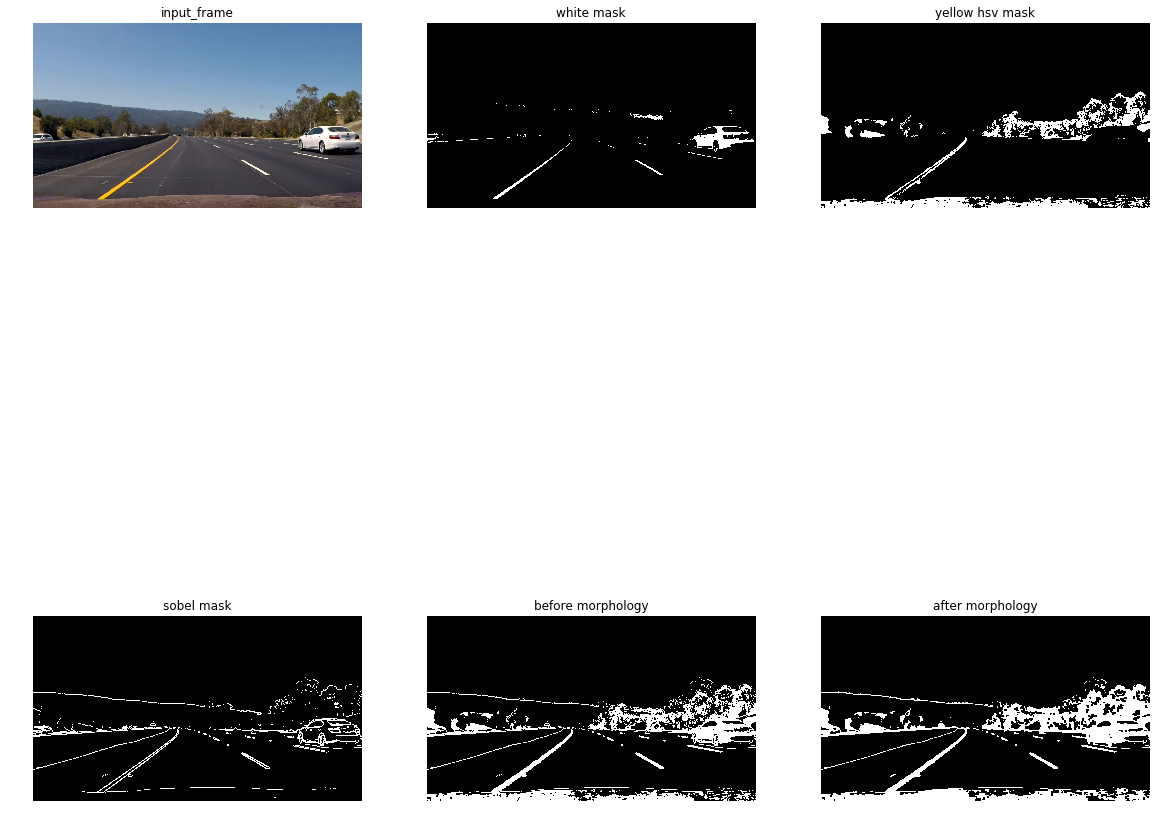

In [8]:
img = mpimg.imread('singleshot/test.jpg')
img = binarize(img, True)